In [5]:
import pandas as pd
import numpy as np
import datetime as dt
#from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines import CoxPHFitter

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import FitFailedWarning
import sksurv.util
import warnings
from lifelines.utils import k_fold_cross_validation

from sklearn.linear_model import LassoCV

from sksurv.preprocessing import OneHotEncoder


df=pd.read_csv("../1_data/private/preprocessed_data.csv")

mask = (df['Visit_yr'] >= 2017) 
df = df.loc[mask]

df_cox=df 

#keep only wb and drbc or rbc
wb=['WB', "DEF PROD", 'WBSB', 'WBMED', 'RBCAPH']
df= df.loc[(df['donation_product_x'] == 'WB') | (df['donation_product_x']== 'RBCAPH')|(df['donation_product_x'] == 'DEF PROD')]
df['donation_product_x'].value_counts()

FileNotFoundError: [Errno 2] No such file or directory: './1_data/private/preprocessed_data.csv'

In [ ]:
#for cox fitter
df_cox2= df.loc[:,['time_to_return', 'CENSORED','Visit_Age',  'first_time' , 'Fixed_mobile' ,'sex', 'donation_product_x' ,'race', 'OUTCOME_TYPE', 
                 'cum_lifetime_donations', 'unit_rbc_loss', 'rbc_loss_last_12_months', 
                 'rbc_loss_last_24_months', 'days_since_last_rbc_loss', 'days_since_last_drbc_loss']]


X3=pd.get_dummies(df_cox2)
X3.fillna(0, inplace=True)
# add interactions
X3['first_time*fixed']=X3["first_time"]*X3['Fixed_mobile']
X3['first_time*hgb']=X3["first_time"]*X3['OUTCOME_TYPE_low hgb']
X3['hgb*fixed']=X3["OUTCOME_TYPE_low hgb"]*X3['Fixed_mobile']

y3= X3['CENSORED']


In [ ]:

# Split the data into training and test sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.9, random_state=0)

# Set up LassoCV model to find optimal penalty
model = LassoCV(cv=5, random_state=0)
model.fit(X_train3, y_train3)

# Get optimal penalty value
penalty = model.alpha_

print(penalty)

# Set up CoxPHFitter model with Lasso penalty
cph = CoxPHFitter(penalizer=penalty)

# Use k-fold cross-validation to fit the model
kf = KFold(n_splits=5, shuffle=True, random_state=0)
scores = []
for train_idx, val_idx in kf.split(X_train3):
    X_train_fold, X_val_fold = X_train3.iloc[train_idx], X_train3.iloc[val_idx]
    y_train_fold, y_val_fold = y_train3.iloc[train_idx], y_train3.iloc[val_idx]
    
    cph.fit(X_train_fold, duration_col='time_to_return', event_col='CENSORED')
    CV_score = cph.score(X_val_fold, scoring_method='concordance_index')
    scores.append(CV_score)

# Print average cross-validation score
print('Average cross-validation score:', sum(scores)/len(scores))


# Fit the model on the entire training set
cph.fit(X_train3, duration_col='time_to_return', event_col='CENSORED')

# Print summary of the model
cph.print_summary()

In [4]:
from forestplot import forestplot
# Extract the coefficients and their confidence intervals
ci = cph.confidence_intervals_['']
coef = cph.hazard_ratios_['']
covariate=['Fixed/Mobile', 'non-hemoglobin deferral', 'RBC lost in past 12 months', 'units of RBC lost', 'RBC lost in the last 24 months', 
           'first time donors at a fixed site (interaction term)', 'Mixed race', 'Male', 'Race: Black', 'Race: White', 'RBC apheresis donation product', 
          'HGB deferral at fixed site (interaction term)',  'Female', 'Unknown race', 'Hemoglobin deferral', 'Race: Asian', 'First time donors']
print(coef)
# Create a dataframe to store the coefficients and their confidence intervals
data = pd.DataFrame({'covariate': coef.index, 'coef': coef, 'lower': ci['95% lower-bound'], 'upper': ci['95% upper-bound']})


data['lower'] = np.exp(data['lower'])
data['upper'] = np.exp(data['upper'])

# Sort the dataframe in descending order of coefficients
data = data.sort_values('coef', ascending=False)

# Create a numpy array of indices for each covariate
ind = np.arange(data.shape[0])


forestplot(data,  # the dataframe with results data
              estimate="coef",  # col containing estimated effect size 
              ll="lower", hl="upper",  # columns containing conf. int. lower and higher limits
              varlabel="covariate",  # column containing variable label
              ylabel="Confidence interval",  # y-label title
              xlabel="Hazard Ratio",  # x-label title
              )
plt.show()

NameError: name 'cph' is not defined

In [4]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

In [ ]:
print(list(df.columns))
#for sklearn
#get dummies of categorical variables
df_cox= df.loc[:,['Visit_Age',  'first_time' , 'Fixed_mobile' ,'sex', 'donation_product_x' ,'ABO_RH' ,'race', 'OUTCOME_TYPE', 
                 'cum_lifetime_donations', 'unit_rbc_loss', 'rbc_loss_last_12_months', 
                 'rbc_loss_last_24_months', 'days_since_last_rbc_loss', 'days_since_last_drbc_loss']]

X=pd.get_dummies(df_cox)

# add interactions
X['first_time*fixed']=X["first_time"]*X['Fixed_mobile']
X['first_time*hgb']=X["first_time"]*X['OUTCOME_TYPE_low hgb']
X['hgb*fixed']=X["OUTCOME_TYPE_low hgb"]*X['Fixed_mobile']

X.fillna(0, inplace=True)
X.head()


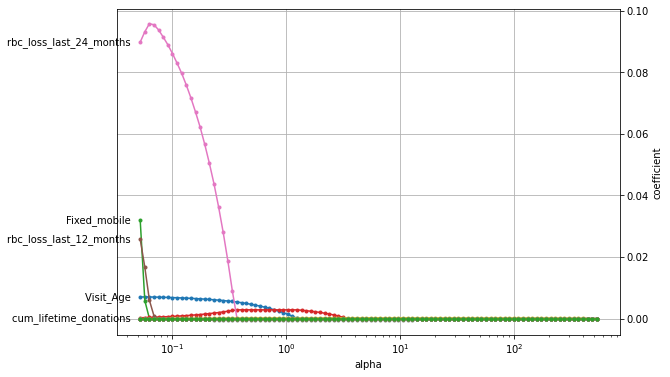

In [5]:
# Lasso Penalized Cox Proportional Hazard Model

   #Structured array

Y= sksurv.util.Surv.from_dataframe('CENSORED', 'time_to_return', df)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.90, random_state=42)

#fit the model
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1, alpha_min_ratio='auto', fit_baseline_model=True)
#cox = CoxPHSurvivalAnalysis()
cox_lasso.fit(X_train, Y_train)


#print(cox_lasso.coef_)


coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=X_train.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=5) 




In [12]:
#make predictions
pred=cox_lasso.predict(X_test)
pred

surv_fns = cox_lasso.predict_survival_function(X_test)
surv_fns